<table style="border:1px solid black;border-collapse:collapse;" align="left">
  <td style="border:1px solid red;">
    <a target="_blank" href="https://colab.research.google.com/github/Grrtzm/word2vec/blob/main/windows_eventlog_anomaly_detection_with_tensorflow_word2vec.ipynb">Run this notebook in Google Colab</a>
  </td>
  <td style="border:1px solid red;">
    <a target="_blank" href="https://github.com/Grrtzm/word2vec/blob/main/windows_eventlog_anomaly_detection_with_tensorflow_word2vec.ipynb">View source on GitHub</a>
  </td>
  <td style="border:1px solid red;">
    <a target="_blank" href="https://www.tensorflow.org/tutorials/text/word2vec">View original Word2Vec tutorial on TensorFlow.org</a>
  </td>
  <td style="border:1px solid red;">
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/text/word2vec.ipynb">Download original Tensorflow Word2Vec tutorial notebook</a>
  </td>
</table>

# Word2Vec on Windows Eventlogs
This notebook is part of a project that uses Word2Vec for anomaly detection in Windows 10 event logs.<br>
It uses a dataset which consists of all events derived from the System event log from my own PC.<br>
The data was read using Powershell and Get-WinEvent. You can find the Powershell script and the python script for parsing in my github repository.<br>
This version uses the Tensorflow implementation of Word2Vec, <a target="_blank" href="https://colab.research.google.com/github/Grrtzm/word2vec/blob/main/windows_eventlog_anomaly_detection_with_gensim_word2vec.ipynb">this version uses a Gensim implementation of Word2Vec</a>.

## Setup

In [1]:
# !pip install gdown      # uncomment if gdown is missing
import gdown
url = 'https://drive.google.com/uc?id=1Kt1FsUwVVTRkpxt7urykgOgDbeOpYRVn'
output = 'System-Events-custom.csv'
gdown.download(url, output, quiet=True)

'System-Events-custom.csv'

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import io
import re
import string
import tqdm
from tensorflow.keras import Model
from tensorflow.keras.layers import Dot, Embedding, Flatten
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

from time import time  # To time our operations
# from collections import defaultdict  # For word frequency
from datetime import datetime # Voor DateTime -> datum bewerkingen

SEED = 42
AUTOTUNE = tf.data.AUTOTUNE

# Set the number of negative samples per positive context.
# Key point: num_ns (number of negative samples per positive context word) 
# between [5, 20] is shown to work best for smaller datasets, while num_ns between [2,5] suffices for larger datasets.
num_ns = 5
window_size = 5
embedding_dim = 20 #  20 seems to be sufficient, 128 is the default value from the tutorial   # Dimension of the dense embedding.
vocab_size = 20000 # inital size of the vocabulary. We will resize it later before defining the model.
sequence_length = 40 # Number of words in a sentence.
epochs = 3000 # Number of training epochs for Word2Vec

df = pd.read_csv('System-Events-custom.csv', parse_dates=["TimeCreated"]) 
df.head()

,TimeCreated,EventRecordID,EventID,Level,Provider,Message
0,2021-12-02 20:05:22.768441+00:00,37593,System_1014,Warning,Microsoft-Windows-DNS-Client,Name resolution for the name config.teams.micr...
1,2021-12-02 20:05:22.255612+00:00,37592,System_32,Information,e1dexpress,NaN
2,2021-12-02 20:05:19.153883+00:00,37591,System_6062,Warning,Netwtw08,6062 - Lso was triggered
3,2021-12-02 20:05:18.362357+00:00,37590,System_27,Warning,e1dexpress,NaN
4,2021-12-02 20:05:18.278408+00:00,37589,System_32,Information,e1dexpress,NaN


## Create Event "word" from multiple columns
This creates a new column containing the words Word2Vec will be trained on.

In [3]:
import string
punct = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{}~'   # `|` is not present here
transtab = str.maketrans(dict.fromkeys(punct, ''))

# Define a function to remove spaces
# https://iqcode.com/code/python/pandas-series-remove-punctuation
# and https://stackoverflow.com/questions/50444346/fast-punctuation-removal-with-pandas
def remove_spaces(text):
    for punctuation in string.punctuation:
        text = text.replace(' ', '')
    return text

# Create a new column. Concatenate the columns, remove unwanted characters and convert to lowercase
df['Event'] = df['EventID'].map(str) + df['Level'].map(str) + df['Provider'].apply(remove_spaces).map(str)
df['Event'] = '|'.join(df['Event'].tolist()).translate(transtab).split('|') # remove all other unwanted characters
df['Event'] = df['Event'].str.lower()

# Delete the redundant columns
df = df.drop(['EventID','Level','Provider'], axis=1)

# Show a preview
df.head(8)

,TimeCreated,EventRecordID,Message,Event
0,2021-12-02 20:05:22.768441+00:00,37593,Name resolution for the name config.teams.micr...,system1014warningmicrosoftwindowsdnsclient
1,2021-12-02 20:05:22.255612+00:00,37592,NaN,system32informatione1dexpress
2,2021-12-02 20:05:19.153883+00:00,37591,6062 - Lso was triggered,system6062warningnetwtw08
3,2021-12-02 20:05:18.362357+00:00,37590,NaN,system27warninge1dexpress
4,2021-12-02 20:05:18.278408+00:00,37589,NaN,system32informatione1dexpress
5,2021-12-02 20:05:17.638712+00:00,37588,The system has returned from a low power state...,system1informationmicrosoftwindowspowertrouble...
6,2021-12-02 20:05:17.544184+00:00,37587,7021 - Connection telemetry fields and analysi...,system7021informationnetwtw08
7,2021-12-02 20:05:15.997321+00:00,37586,Windows cannot store Bluetooth authentication ...,system18informationbthusb


In [4]:
num_rows = len(df.axes[0])
print(f"Number of lines/events in the dataset: {num_rows}\n")

Number of lines/events in the dataset: 37593



## Create csv file corpus

Create the text dataset "eventlist", a list containing "eventrow" lists. An "eventrow" list contains all events for that day.

In [5]:
minlength = 1e6
maxlength = 0
eventlist = []
eventrow = []
previous_date = None # datetime.now().date()
for idx, row in df.iterrows():
    date = row['TimeCreated'].date()
    eventrow.append(row['Event'])
    if date != previous_date:
        length = len(eventrow) + 1
        if length > maxlength: maxlength = length
        if length < minlength: minlength = length
        eventrow = []
        eventlist.append(eventrow)
        previous_date = date
        
print(f"Number of lines = {len(eventlist)}, shortest line = {minlength} words, longest line = {maxlength} words\n")

# Ugly, but the easiest way. Save the list to a csv file and read that as a text file.
# Save the dataset as a csv file using the numpy module
events = np.array(eventlist, dtype=object)
np.savetxt('eventlist.csv', events, delimiter=',', fmt ='% s')

Number of lines = 263, shortest line = 2 words, longest line = 1011 words



In [6]:
print(f"`sequence_length` is changed now from {sequence_length} to {maxlength}")
sequence_length = maxlength

`sequence_length` is changed now from 40 to 1011


### Vectorize sentences from the corpus

In [7]:
path_to_file = "eventlist.csv"

print(f"File containing log events: {path_to_file}\n")

# Use the non empty lines to construct a tf.data.TextLineDataset object for next steps.
text_ds = tf.data.TextLineDataset(path_to_file).filter(lambda x: tf.cast(tf.strings.length(x), bool))

'''
# Uncomment this block to see how the data (tensors) looks like.
for line in text_ds.take(10):
    print(line)
print(f"Those were the tensors\n")

print(text_ds)
print()
'''

# Now, create a custom standardization function to lowercase the text and remove punctuation.
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    return tf.strings.regex_replace(lowercase,
    '[%s]' % re.escape(string.punctuation), '')

# Use the text vectorization layer to normalize, split, and map strings to
# integers. Set output_sequence_length length to pad all samples to same length.
vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size, # None
    output_mode='int',
    output_sequence_length=sequence_length)

# Call adapt on the text dataset to create vocabulary.
vectorize_layer.adapt(text_ds.batch(1024))

# Save the created vocabulary for reference.
inverse_vocab = vectorize_layer.get_vocabulary()
print(f"Number of words in vocabulary (limit is {vocab_size}): {len(inverse_vocab)-1}")

# Vectorize the data in text_ds.
text_vector_ds = text_ds.batch(1024).prefetch(AUTOTUNE).map(vectorize_layer).unbatch()

# Obtain number of sequences from the dataset
sequences = list(text_vector_ds.as_numpy_iterator())

print(f"First 10 sequences:\n")
idx = 0
for seq in sequences:
    print(seq)
    idx = idx + 1
    if idx > 10: break

File containing log events: eventlist.csv

Number of words in vocabulary (limit is 20000): 192
First 10 sequences:

[32 11 47 ...  0  0  0]
[5 3 3 ... 0 0 0]
[ 5 14 26 ...  0  0  0]
[14 26 42 ...  0  0  0]
[ 5  9 41 ...  0  0  0]
[ 5 14 26 ...  0  0  0]
[14 26  2 ...  0  0  0]
[14 26 13 ...  0  0  0]
[ 5 14 26 ...  0  0  0]
[ 5 47 14 ...  0  0  0]
[ 5 14 26 ...  0  0  0]


## Show the vocabulary

In [8]:
vocab_len = len(inverse_vocab)
print(f"Number of words in vocabulary (limit is {vocab_size}): {vocab_len - 1}\n")
v = 0
for i in range(vocab_len):
    if i>0: 
        # I needed to shift the weight index in order to match the values from u with the inverse_vocab
        # u = vectorize_layer.get_weights()[0][i-2]
        v = vectorize_layer.get_weights()[1][i-2]
    w = inverse_vocab[i]
    print(f"Index {i}:\tWeight:{v}\t{w}")
    #if i > 5: break # only show the first 5

Number of words in vocabulary (limit is 20000): 192

Index 0:	Weight:0	
Index 1:	Weight:0	[UNK]
Index 2:	Weight:2	system7040informationservicecontrolmanager
Index 3:	Weight:3	system16informationmicrosoftwindowskernelgeneral
Index 4:	Weight:104	system10016warningmicrosoftwindowsdistributedcom
Index 5:	Weight:5	system7021informationnetwtw08
Index 6:	Weight:39	system55informationmicrosoftwindowskernelprocessorpower
Index 7:	Weight:54	system6informationmicrosoftwindowsfiltermanager
Index 8:	Weight:4	system1informationgoogledrivefs3525
Index 9:	Weight:52	system1informationmicrosoftwindowskernelgeneral
Index 10:	Weight:21	system7003informationnetwtw08
Index 11:	Weight:20	system6062warningnetwtw08
Index 12:	Weight:72	system18informationbthusb
Index 13:	Weight:8	system1014warningmicrosoftwindowsdnsclient
Index 14:	Weight:6	system42informationmicrosoftwindowskernelpower
Index 15:	Weight:51	system1informationmicrosoftwindowspowertroubleshooter
Index 16:	Weight:7	system107informationmicrosoftwind

### Helper function to generate training data
Generates skip-gram pairs with negative sampling for a list of sequences (int-encoded sentences) 
based on window size, number of negative samples and vocabulary size.

In [9]:
def generate_training_data(sequences, window_size, num_ns, vocab_size, seed):
    # Elements of each training example are appended to these lists.
    targets, contexts, labels = [], [], []

    # Build the sampling table for vocab_size tokens.
    sampling_table = tf.keras.preprocessing.sequence.make_sampling_table(vocab_size)

    # Iterate over all sequences (sentences) in dataset.
    for sequence in tqdm.tqdm(sequences):
        #print(type(sequence))
        #break

        # Generate positive skip-gram pairs for a sequence (sentence).
        positive_skip_grams, _ = tf.keras.preprocessing.sequence.skipgrams(
              sequence,
              vocabulary_size=vocab_size,
              sampling_table=sampling_table,
              window_size=window_size,
              negative_samples=0)

        # Iterate over each positive skip-gram pair to produce training examples
        # with positive context word and negative samples.
        for target_word, context_word in positive_skip_grams:
            context_class = tf.expand_dims(
                tf.constant([context_word], dtype="int64"), 1)
            negative_sampling_candidates, _, _ = tf.random.log_uniform_candidate_sampler(
                true_classes=context_class,
                num_true=1,
                num_sampled=num_ns,
                unique=True,
                range_max=vocab_size,
                seed=SEED,
                name="negative_sampling")

            # Build context and label vectors (for one target word)
            negative_sampling_candidates = tf.expand_dims(
                negative_sampling_candidates, 1)

            context = tf.concat([context_class, negative_sampling_candidates], 0)
            label = tf.constant([1] + [0]*num_ns, dtype="int64")

            # Append each element from the training example to global lists.
            targets.append(target_word)
            contexts.append(context)
            labels.append(label)

    return targets, contexts, labels

### Generate training examples from sequences
`sequences` is now a list of int encoded sentences.

In [10]:
print(f"Genererate training examples from sequences, using: window_size={window_size}, num_ns={num_ns}, vocab_size={vocab_len}, seed={SEED}")
import time
time.sleep(1) # Nodig om tekst op de juiste plaats terecht te laten komen (i.v.m. multi-threading)
targets, contexts, labels = generate_training_data(
    # sequences=sequences,
    sequences=sequences,
    window_size=window_size,
    num_ns=num_ns,
    vocab_size=vocab_len,
    seed=SEED)
time.sleep(1) # Nodig om tekst op de juiste plaats terecht te laten komen (i.v.m. multi-threading)
print(f"Number of training examples; targets:{len(targets)}, contexts:{len(contexts)}, labels:{len(labels)}")

# Configure the dataset for performance
BATCH_SIZE = len(targets)
BUFFER_SIZE = 10000
dataset = tf.data.Dataset.from_tensor_slices(((targets, contexts), labels))
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

# Add cache() and prefetch() to improve performance.
dataset = dataset.cache().prefetch(buffer_size=AUTOTUNE)

Genererate training examples from sequences, using: window_size=5, num_ns=5, vocab_size=193, seed=42


100%|██████████| 263/263 [00:03<00:00, 87.19it/s] 


Number of training examples; targets:9933, contexts:9933, labels:9933


### Model and Training

In [11]:
class trainingCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.9):
            print(f"\nReached 90% accuracy in {epoch+1} epochs. Ended training...")
            self.model.stop_training = True

class Word2Vec(Model):
    def __init__(self, vocab_size, embedding_dim):
        super(Word2Vec, self).__init__()
        self.target_embedding = Embedding(vocab_size,
                                      embedding_dim,
                                      input_length=1,
                                      name="w2v_embedding")
        self.context_embedding = Embedding(vocab_size,
                                       embedding_dim,
                                       input_length=num_ns+1)
        self.dots = Dot(axes=(3, 2))
        self.flatten = Flatten()

    def call(self, pair):
        target, context = pair
        word_emb = self.target_embedding(target)
        context_emb = self.context_embedding(context)
        dots = self.dots([context_emb, word_emb])
        
        return self.flatten(dots)

# Define loss function and compile model
#embedding_dim = 128
model = Word2Vec(vocab_len, embedding_dim)
model.compile(optimizer='adam',
                 loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                 metrics=['accuracy'])

# Train the model with dataset prepared above for some number of epochs.
print("Training Word2Vec...")
history = model.fit(dataset, epochs=epochs, verbose=0, callbacks=[trainingCallback()]) # verbose=0 means no output, verbose=1 shows logging

Training Word2Vec...


In [12]:
model.summary()

Model: "word2_vec"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
w2v_embedding (Embedding)    multiple                  3860      
_________________________________________________________________
embedding (Embedding)        multiple                  3860      
_________________________________________________________________
dot (Dot)                    multiple                  0         
_________________________________________________________________
flatten (Flatten)            multiple                  0         
Total params: 7,720
Trainable params: 7,720
Non-trainable params: 0
_________________________________________________________________


### Show some training plots

<Figure size 432x288 with 0 Axes>

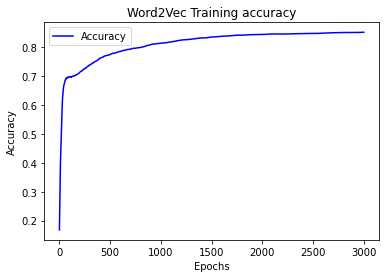

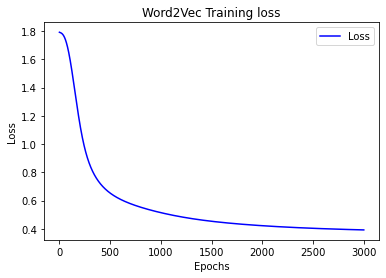

<Figure size 432x288 with 0 Axes>

In [13]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

acc=history.history['accuracy']
loss=history.history['loss']

epochs=range(len(acc)) # Get number of epochs

plt.plot(epochs, acc, 'b')
plt.title('Word2Vec Training accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy"])
plt.figure()

plt.plot(epochs, loss, 'b')
plt.title('Word2Vec Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])
plt.figure()

### Embedding lookup and analysis
Download the vectors.tsv and metadata.tsv to analyze the obtained embeddings in the Embedding Projector.

In [14]:
weights = model.get_layer('w2v_embedding').get_weights()[0]
vocab = vectorize_layer.get_vocabulary()

# Create and save the vectors and metadata file
out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(vocab):
    if index < 1:
        continue  # skip 0, it's padding
    vec = weights[index]
    out_v.write('\t'.join([str(x) for x in vec]) + "\n")
    out_m.write(word + "\n")
out_v.close()
out_m.close()

Run the cell below to download the `vectors.tsv` and `metadata.tsv` to analyze the obtained embeddings in the [Embedding Projector](https://projector.tensorflow.org/).

In [15]:
try:
    from google.colab import files
    files.download('vectors.tsv')
    files.download('metadata.tsv')
except Exception:
    pass

## Calculate `cosine_similarity` for each event
And add these as a a column to the dataset.

In [16]:
from numpy import dot
from numpy.linalg import norm

def vocab_lookup(eventstr):
    for index, word in enumerate(vocab):
        if index < 1:
            continue  # skip 0, it's padding
        if word == eventstr:
            vec = weights[index]
            break
    return vec

num_events = len(df.axes[0])
# add empty columns
cos_sim = []
for idx, row in df.iterrows():
    current_event = row['Event']
    ce = vocab_lookup(current_event)
    if idx == 0:
        cos_sim.append(float(1))
        previous_event = current_event
        pe = ce
    if idx > 0:
        if idx < num_events + 1:
            cs = dot(pe, ce)/(norm(pe)*norm(ce)) # https://www.statology.org/cosine-similarity-python/
            cos_sim.append(cs)
            previous_event = current_event
            pe = ce

df['cos_sim'] = cos_sim

# Change order of columns by name, so we can display it orderly
df = df[['TimeCreated', 'EventRecordID', 'Event', 'cos_sim', 'Message']]
df.head()

# saving the dataframe
df.to_csv('System-Events-similarity-Tensorflow.csv')

## Plot all anomalies
The lower the line spikes, the more unique it is.

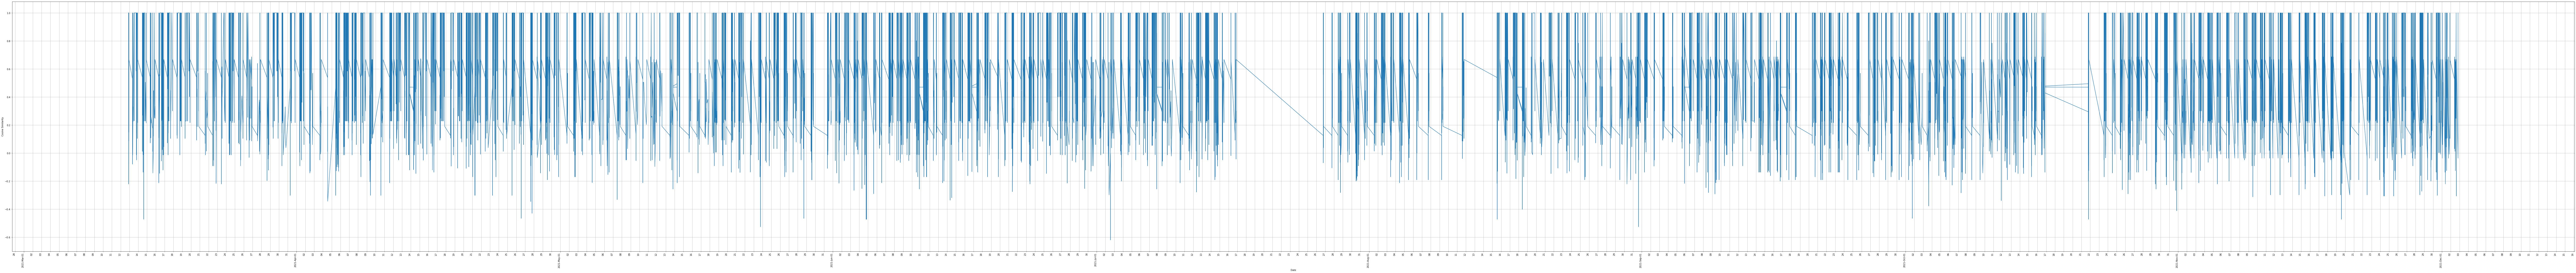

In [17]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

fig, ax = plt.subplots(1, figsize=(200, 20))
x = df['TimeCreated']
y = df['cos_sim']
line, = ax.plot(x, y)
# Major ticks every month, minor ticks every day,
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_minor_locator(mdates.DayLocator())
ax.grid(True, which='both', axis='both')
# Text in the x axis will be displayed in 'YYYY-mm-dd' format.
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b-%d'))
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%d'))
# Rotates and right-aligns the x labels so they don't crowd each other.
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=90, horizontalalignment='right')
for label in ax.get_xticklabels(which='minor'):
    label.set(rotation=90, horizontalalignment='right')
plt.xlabel("Date")
plt.ylabel("Cosine Similarity")
plt.savefig("cos_sim_tensorflow.png", format="png")
plt.show()

## Show Top 10 of all 'anomalies'

In [18]:
# Pandas display settings
pd.set_option('display.max_columns', None) # Set it to None to display all columns in the dataframe
pd.set_option('display.width',200)
pd.set_option('display.max_colwidth', None)

print("Top 10 of all 'anomalies':\n")
df.nsmallest(n=10, columns=['cos_sim'])

Top 10 of all 'anomalies':



,TimeCreated,EventRecordID,Event,cos_sim,Message
21697,2021-07-02 13:48:01.095899+00:00,15896,system18informationbthusb,-0.619508,Windows cannot store Bluetooth authentication codes (link keys) on the local adapter. Bluetooth keyboards might not work in the system BIOS during start-up.
14431,2021-08-31 15:15:37.990200+00:00,23162,system16informationmicrosoftwindowskernelgeneral,-0.525484,The access history in hive \??\C:\WINDOWS\AppCompat\Programs\Amcache.hve was cleared updating 6876 keys and creating 2626 modified pages.
27874,2021-05-23 18:35:12.545229+00:00,9719,system16informationmicrosoftwindowskernelgeneral,-0.525484,The access history in hive \??\C:\WINDOWS\AppCompat\Programs\Amcache.hve was cleared updating 5562 keys and creating 2161 modified pages.
3168,2021-11-19 13:49:22.512350+00:00,34425,system24620errormicrosoftwindowsbitlockerdriver,-0.472167,Encrypted volume check: Volume information on E: cannot be read.
7238,2021-10-21 19:23:30.053944+00:00,30355,system24577informationmicrosoftwindowswpdclassinstaller,-0.471799,"Media player and imaging program compatibility layers were successfully registered for device USB\VID_04E8&PID_6860&REV_0400&MS_COMP_MTP&SAMSUNG_Android. Layer bits 0x00000003 were requested, layer bits 0x00000003 were registered."
16569,2021-08-15 13:20:37.504412+00:00,21024,system24577informationmicrosoftwindowswpdclassinstaller,-0.471799,"Media player and imaging program compatibility layers were successfully registered for device USB\VID_04A9&PID_315A&REV_0002. Layer bits 0x00000001 were requested, layer bits 0x00000001 were registered."
25681,2021-06-04 20:06:43.634191+00:00,11912,system24577informationmicrosoftwindowswpdclassinstaller,-0.471799,"Media player and imaging program compatibility layers were successfully registered for device USB\VID_04CB&PID_01D4&REV_0100. Layer bits 0x00000001 were requested, layer bits 0x00000001 were registered."
25691,2021-06-04 20:01:20.171263+00:00,11902,system24577informationmicrosoftwindowswpdclassinstaller,-0.471799,"Media player and imaging program compatibility layers were successfully registered for device USB\VID_07CF&PID_125A&REV_0100. Layer bits 0x00000001 were requested, layer bits 0x00000001 were registered."
25710,2021-06-04 18:54:55.268595+00:00,11883,system24577informationmicrosoftwindowswpdclassinstaller,-0.471799,"Media player and imaging program compatibility layers were successfully registered for device USB\VID_04A9&PID_315A&REV_0002. Layer bits 0x00000001 were requested, layer bits 0x00000001 were registered."
36827,2021-03-14 15:05:31.079574+00:00,766,system24577informationmicrosoftwindowswpdclassinstaller,-0.471799,"Media player and imaging program compatibility layers were successfully registered for device USB\VID_04E8&PID_6860&REV_0400&MS_COMP_MTP&SAMSUNG_Android. Layer bits 0x00000003 were requested, layer bits 0x00000003 were registered."


As you can see above, those anomalies are not always not what you expected. We are not interested in 'Information' events. 
<br> Now lets take a look at some more interesting events.
## Show Top 10 of 'critical' anomalies

In [19]:
dfcritical = df[df['Event'].str.contains('critical')]
print(f"Top 10 of 'critical' anomalies from a total of {len(dfcritical)} 'critical' events:\n")
dfcritical.nsmallest(n=10, columns=['cos_sim'])

Top 10 of 'critical' anomalies from a total of 14 'critical' events:



,TimeCreated,EventRecordID,Event,cos_sim,Message
570,2021-11-30 11:19:04.976339+00:00,37023,system41criticalmicrosoftwindowskernelpower,0.857287,"The system has rebooted without cleanly shutting down first. This error could be caused if the system stopped responding, crashed, or lost power unexpectedly."
9440,2021-10-01 18:28:17.428702+00:00,28153,system41criticalmicrosoftwindowskernelpower,0.857287,"The system has rebooted without cleanly shutting down first. This error could be caused if the system stopped responding, crashed, or lost power unexpectedly."
14500,2021-08-31 15:15:12.123075+00:00,23093,system41criticalmicrosoftwindowskernelpower,0.857287,"The system has rebooted without cleanly shutting down first. This error could be caused if the system stopped responding, crashed, or lost power unexpectedly."
26725,2021-05-28 16:46:49.554694+00:00,10868,system41criticalmicrosoftwindowskernelpower,0.857287,"The system has rebooted without cleanly shutting down first. This error could be caused if the system stopped responding, crashed, or lost power unexpectedly."
27941,2021-05-23 18:34:47.785323+00:00,9652,system41criticalmicrosoftwindowskernelpower,0.857287,"The system has rebooted without cleanly shutting down first. This error could be caused if the system stopped responding, crashed, or lost power unexpectedly."
30925,2021-04-26 13:11:40.205236+00:00,6668,system41criticalmicrosoftwindowskernelpower,0.857287,"The system has rebooted without cleanly shutting down first. This error could be caused if the system stopped responding, crashed, or lost power unexpectedly."
31140,2021-04-25 12:11:55.396258+00:00,6453,system41criticalmicrosoftwindowskernelpower,0.857287,"The system has rebooted without cleanly shutting down first. This error could be caused if the system stopped responding, crashed, or lost power unexpectedly."
31401,2021-04-23 06:53:59.632369+00:00,6192,system41criticalmicrosoftwindowskernelpower,0.857287,"The system has rebooted without cleanly shutting down first. This error could be caused if the system stopped responding, crashed, or lost power unexpectedly."
31674,2021-04-21 07:02:53.221205+00:00,5919,system41criticalmicrosoftwindowskernelpower,0.857287,"The system has rebooted without cleanly shutting down first. This error could be caused if the system stopped responding, crashed, or lost power unexpectedly."
31759,2021-04-21 07:00:39.765228+00:00,5834,system41criticalmicrosoftwindowskernelpower,0.857287,"The system has rebooted without cleanly shutting down first. This error could be caused if the system stopped responding, crashed, or lost power unexpectedly."


## Show Top 10 of 'error' anomalies

In [20]:
dferror = df[df['Event'].str.contains('error')]
print(f"Top 10 of 'error' anomalies from a total of {len(dferror)} 'error' events:\n")
dferror.nsmallest(n=10, columns=['cos_sim'])

Top 10 of 'error' anomalies from a total of 1054 'error' events:



,TimeCreated,EventRecordID,Event,cos_sim,Message
3168,2021-11-19 13:49:22.512350+00:00,34425,system24620errormicrosoftwindowsbitlockerdriver,-0.472167,Encrypted volume check: Volume information on E: cannot be read.
14430,2021-08-31 15:15:40.517659+00:00,23163,system1001errormicrosoftwindowswersystemerrorreporting,-0.465421,"The computer has rebooted from a bugcheck. The bugcheck was: 0x00000109 (0xa3a004e23def3663, 0x0000000000000000, 0x1049d96c353a27eb, 0x0000000000000101). A dump was saved in: C:\WINDOWS\MEMORY.DMP. Report Id: 188d660c-6628-4f32-be56-781624281ae2."
26665,2021-05-28 16:47:09.837706+00:00,10928,system1001errormicrosoftwindowswersystemerrorreporting,-0.465421,"The computer has rebooted from a bugcheck. The bugcheck was: 0x0000001a (0x0000000000061948, 0x0000000001008000, 0x0000000000000001, 0x0000000001008000). A dump was saved in: C:\WINDOWS\MEMORY.DMP. Report Id: 983ac434-d271-4a0e-9de0-6eaf64583e30."
27873,2021-05-23 18:35:15.357416+00:00,9720,system1001errormicrosoftwindowswersystemerrorreporting,-0.465421,"The computer has rebooted from a bugcheck. The bugcheck was: 0x0000001a (0x0000000000061948, 0x0000000001008000, 0x0000000000000001, 0x0000000001008000). A dump was saved in: C:\WINDOWS\MEMORY.DMP. Report Id: d8b55560-809f-4550-aba8-25b45a3106aa."
30868,2021-04-26 13:12:01.443939+00:00,6725,system1001errormicrosoftwindowswersystemerrorreporting,-0.465421,"The computer has rebooted from a bugcheck. The bugcheck was: 0x0000003b (0x00000000c0000005, 0xfffff8041d896d93, 0xfffff601f75b6af0, 0x0000000000000000). A dump was saved in: C:\WINDOWS\MEMORY.DMP. Report Id: b380d75b-57ae-4626-a341-c543ad9e6c79."
30788,2021-04-27 15:16:29.061505+00:00,6805,system20errormicrosoftwindowswindowsupdateclient,-0.345491,Installation Failure: Windows failed to install the following update with error 0x8024200B: Security Intelligence Update for Microsoft Defender Antivirus - KB2267602 (Version 1.337.41.0).
997,2021-11-28 17:07:50.994243+00:00,36596,system4207errortcpip,-0.272104,The IPv4 TCP/IP interface with index 15 failed to bind to its provider.
21924,2021-06-29 15:20:41.355037+00:00,15669,system20errormicrosoftwindowswindowsupdateclient,-0.253138,Installation Failure: Windows failed to install the following update with error 0x8024200B: Security Intelligence Update for Microsoft Defender Antivirus - KB2267602 (Version 1.343.25.0).
25929,2021-06-04 07:23:27.914743+00:00,11664,system20errormicrosoftwindowswindowsupdateclient,-0.253138,Installation Failure: Windows failed to install the following update with error 0x8024200B: Security Intelligence Update for Microsoft Defender Antivirus - KB2267602 (Version 1.341.28.0).
6095,2021-10-30 16:18:10.626772+00:00,31498,system5005errornetwtw08,-0.226609,Intel(R) Wireless-AC 9560 160MHz : Has encountered an internal error and has failed.
